# Objective:

Designing a 6/12/24 hours ahead water inflow forecast.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from operator import itemgetter
from IPython.display import display
from ipywidgets import SelectMultiple, interact, IntProgress, IntSlider

from typing import Union, Optional, Callable

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.utils.missing_values import extract_subseries
from darts.models import NaiveMovingAverage, RegressionModel, XGBModel
from darts.models.forecasting.forecasting_model import ForecastingModel

## Loading data

- We inmediatly transform the target and precipitation by computing their logarithm. This step will _squeeze_ their values which can help during training.

In [2]:
data = pd.read_csv("../processed/data.csv", index_col=0, parse_dates=True)

In [ ]:
data.rename(columns={"FB20F11_81": "flow"}, inplace=True)
data[["flow", "acc_precip"]] = data[["flow", "acc_precip"]].apply(np.log1p)

# These variables have a big gap at the end, so we discard them
data.drop(columns=["temp_grass", "temp_soil_10", "temp_soil_30"], inplace=True)

# For later convenience, we will work with darts TimeSeries
ts = TimeSeries.from_dataframe(data, freq="h")

- Splitting into continuous timeseries

Given the gaps in the datat, we will work with a list of `TimeSeries`. This will require all transformations to be applied to each subseries. 

In [17]:
subseries = extract_subseries(ts, mode="any")

min_length = 24 * 7  # 7 days
subseries = [s for s in subseries if len(s) >= min_length]

print(f"Total number of usable samples {sum([len(s) for s in subseries])}")

Total number of usable samples 9304


- The dynamics of observed precipitation are faster than their effects. We smooth the precipitation by using a Holt exponential smoother; the value of the parameter $\alpha$ is chosen based on the correlation study in the overview [notebook](./overview.ipynb).

In [18]:
def holt_smoother(x: np.array, alpha: float) -> np.array:
    # https://empslocal.ex.ac.uk/people/staff/dbs202/cag/courses/MT37C/course/node102.html
    y = np.zeros_like(x)
    y[0] = x[0]

    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t - 1]

    return y


alpha = 0.2
for series in subseries:
    lp_precip = holt_smoother(series["acc_precip"].values().ravel(), alpha)
    ts_lp = TimeSeries.from_series(
        pd.Series(lp_precip, index=series.time_index, name="smooth_precip")
    )
    series = series.concatenate(ts_lp, axis=1)

- Splitting subseries between target and covariates

In [19]:
target_subseries = [s["flow"] for s in subseries]
covariates_subseries = [s.drop_columns("flow") for s in subseries]

- We include polynomial functions of the weather features

In [ ]:
def generate_poly_ts(ts: TimeSeries, degree: int) -> TimeSeries:
    poly_values = PolynomialFeatures(degree, include_bias=False).fit_transform(
        ts.values()
    )
    poly_features = pd.DataFrame(
        poly_values,
        columns=[f"feature_{i}" for i in range(poly_values.shape[1])],
        index=ts.time_index,
    )

    return TimeSeries.from_dataframe(
        poly_features,
        freq="h",
    )


deg = 3  # polynomial degree
poly_covariates = [generate_poly_ts(s, deg) for s in covariates_subseries]

- We include datetime features, using one hot encoding

In [21]:
def generate_datetime_ts(ts: TimeSeries) -> TimeSeries:
    """Generates time series of date time features using one hot encoding"""
    dayofweek = (
        pd.get_dummies(ts.time_index.day_of_week)
        .rename(columns=lambda x: f"dow_{x}")
        .set_index(ts.time_index)
    )
    hours = (
        pd.get_dummies(ts.time_index.hour)
        .rename(columns=lambda x: f"hour_{x}")
        .set_index(ts.time_index)
    )

    datetime_features = dayofweek.merge(
        hours, left_index=True, right_index=True
    ).astype(int)

    return TimeSeries.from_dataframe(datetime_features)


datetime_covariates = [generate_datetime_ts(s) for s in covariates_subseries]

(Text(0, 0.5, 'Flow [...]'), Text(0, 0.5, 'Acc. Precip. [...]'))

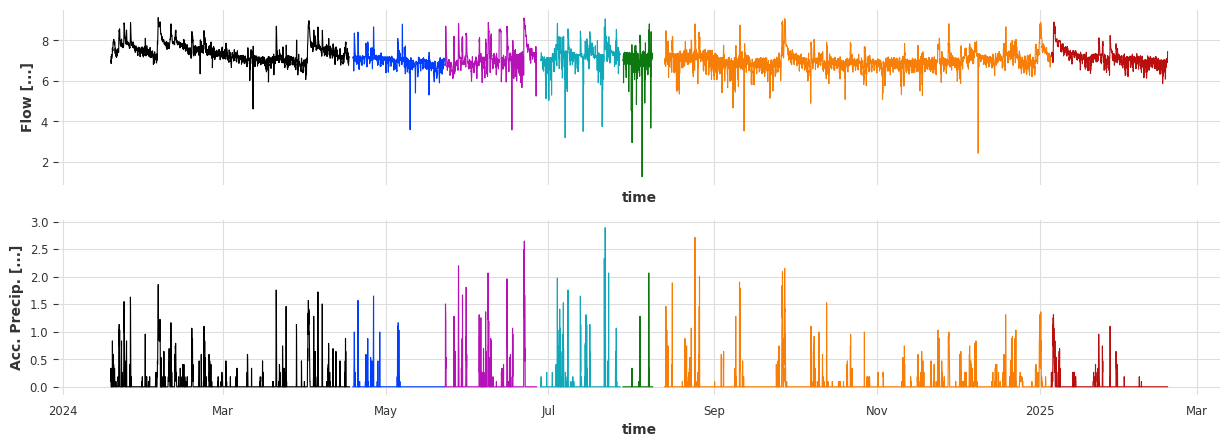

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
for s1, s2 in zip(target_subseries, covariates_subseries):
    s1.plot(ax=axes[0], linewidth=0.8)
    s2["acc_precip"].plot(ax=axes[1], linewidth=0.8)
axes[0].legend().set_visible(False), axes[1].legend().set_visible(False)
axes[0].set_ylabel("Flow [...]"), axes[1].set_ylabel("Acc. Precip. [...]")

## Modelling

In [ ]:
n_subseries = len(target_subseries)
n_features = poly_covariates[0].n_components + datetime_covariates[0].n_components

train_index = list(range(0, 2)) + list(range(3, n_subseries))
test_index = [2]

assert len(set(test_index).intersection(train_index)) == 0

train_getter = itemgetter(*train_index)
test_getter = itemgetter(*test_index)

In [36]:
train_target = train_getter(target_subseries)
test_target = test_getter(target_subseries)

train_past_covariates = train_getter(poly_covariates)
test_past_covariates = test_getter(poly_covariates)

train_future_covariates = train_getter(datetime_covariates)
test_future_covariates = test_getter(datetime_covariates)

In [35]:
output_chunk_length = 24
n_lags = 48

### Baseline

In [39]:
naive = NaiveMovingAverage(input_chunk_length=n_lags)

### Candidates

In [40]:
encoders = {"cyclic": {"future": "month"}}

regmodel = RegressionModel(
    model=Ridge(fit_intercept=False, solver="lsqr"),
    lags=n_lags,
    lags_future_covariates=(0, 1),
    lags_past_covariates=n_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

xgbmodel = XGBModel(
    lags=n_lags,
    lags_future_covariates=(0, 1),
    lags_past_covariates=n_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

We define the `Model` class to better access the model and its estimator (will be used during feature selection).

In [41]:
class Model:
    def __init__(self, model: Union[RegressionModel, XGBModel]):
        self.model = model
        self.estimator = model.get_estimator(0, 0)


ridge = Model(regmodel)
xgb = Model(xgbmodel)

Model supports multi-output; a single estimator forecasts all the horizons and components.
Model supports multi-output; a single estimator forecasts all the horizons and components.


In [42]:
candidate = xgb

#### Feature selection
- In order to select features I run RFECV on every subseries. I will select the features that were selected in more than half of the subseries.

In [43]:
pbar = IntProgress(min=0, max=len(train_target))
display(pbar)

original_past_components = train_past_covariates[0].components
original_future_components = train_future_covariates[0].components

used_features = np.zeros(n_features)
train_covariates = [
    past_cov.concatenate(future_cov, axis=1)
    for past_cov, future_cov in zip(train_past_covariates, train_future_covariates)
]
test_covariates = test_past_covariates.concatenate(test_future_covariates, axis=1)

for target_i, covariates_i in zip(train_target, train_covariates):
    # Here, the estimator is not taking the past into account
    selector = RFECV(
        candidate.estimator,
        step=0.05,
        min_features_to_select=5,
        cv=TimeSeriesSplit(n_splits=4),
    )

    # The selection is made taking into account only the next time step
    selector = selector.fit(covariates_i.values(), target_i.values())
    used_features += selector.support_.astype(int)
    pbar.value += 1

# We only select features that have been selected in at least half of the subseries
index_relevant_features = [
    int(i) for i in np.where(used_features / n_subseries >= 0.5)[0]
]

selected_components = list(train_covariates[0].components[index_relevant_features])

print(len(selected_components))

IntProgress(value=0, max=6)

19


In [ ]:
past_components = [fn for fn in selected_components if fn in original_past_components]
future_components = [
    fn for fn in selected_components if fn in original_future_components
]

if len(past_components) > 0:
    selected_components_past_train = [s[past_components] for s in train_covariates]
    selected_components_past_test = test_covariates[past_components]
else:
    selected_components_past_train = selected_components_past_test = None

if len(future_components) > 0:
    selected_train_future_covariates = [s[future_components] for s in train_covariates]
    selected_test_future_covariates = test_covariates[future_components]
else:
    selected_train_future_covariates = selected_test_future_covariates = None

In [45]:
candidate.model.fit(
    train_target,
    past_covariates=selected_components_past_train,
    future_covariates=selected_train_future_covariates,
)

Fitting was called with `add_encoders` and suspicion of lazy loading. The encodings/covariates are generated pre-train for all individual targets and loaded into memory. Depending on the size of your data, this can create memory issues. In case this applies, consider setting `add_encoders=None` at model creation.


XGBModel(lags=48, lags_past_covariates=48, lags_future_covariates=(0, 1), output_chunk_length=24, output_chunk_shift=0, add_encoders={'cyclic': {'future': 'month'}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [46]:
candidate.estimator.n_features_in_

492

Despite the number of selected features is relatively small, once we include their lags, the number of features greatly increases.

## Testing

In [48]:
feature_i = SelectMultiple(
    options=past_components,
    value=past_components[:1],
    description="Features to compare",
)

nudger = IntSlider(min=-12, max=12, value=0, description="Nudge pred. start")


@interact(features=feature_i, nudge=nudger)
def plot_forecast(features, nudge):
    arbitrary_breakpoints = [70, 85, 350, 532, 568]  # Needs to be above n_lags
    fig, axes = plt.subplots(
        2, len(arbitrary_breakpoints), figsize=(20, 5), sharey="row", sharex="col"
    )
    for i, n_split in enumerate(arbitrary_breakpoints):
        time_axis = test_target.slice(
            test_target.time_index[n_split - n_lags],
            test_target.time_index[n_split + output_chunk_length],
        ).time_index
        minx = time_axis.min()
        maxx = time_axis.max()

        test_in, test_out = test_target.split_before(n_split + nudge)

        predicted_inflow = candidate.model.predict(
            series=test_in,
            n=output_chunk_length,
            past_covariates=selected_components_past_test,
            future_covariates=selected_test_future_covariates,
        )

        actual_inflow = test_target.slice(start_ts=minx, end_ts=maxx)

        predicted_inflow.plot(label="predicted", ax=axes[0, i])
        actual_inflow.plot(label="actual", ax=axes[0, i])

        selected_components_past_test[list(features)].slice_intersect(
            actual_inflow
        ).plot(ax=axes[1, i])

        axes[0, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")
        axes[1, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")

        axes[0, i].set_xlim(minx, maxx)
        axes[1, i].set_xlim(minx, maxx)

    plt.tight_layout()


interactive(children=(SelectMultiple(description='Features to compare', index=(0,), options=('feature_1', 'fea…

- At every step of the test series, we forecast the next 6/12/24 hours and compare.

In [49]:
def compute_errors(
    ts: TimeSeries,
    model: ForecastingModel,
    horizon: int,
    *,
    past_covariates: Optional[TimeSeries] = None,
    future_covariates: Optional[TimeSeries] = None,
    output_transform: Optional[Callable] = None,
    is_naive: bool = False,
):
    n_lags = abs(model.extreme_lags[0])

    n_steps = len(ts) - n_lags - horizon
    pbar2 = IntProgress(min=0, max=n_steps)
    display(pbar2)

    errors = []
    for t in range(n_steps):
        ts_in, ts_out = ts.split_before(t + n_lags)

        kwargs = {}
        if model.supports_future_covariates:
            kwargs["past_covariates"] = past_covariates
            kwargs["future_covariates"] = future_covariates
        if model.supports_transferrable_series_prediction:
            kwargs["series"] = ts_in
        if is_naive:
            # Naive models can only _continue_ the series they have been trained on
            model.fit(ts_in)

        pred = model.predict(
            horizon,
            **kwargs,
        )

        actual_values = ts_out.slice_intersect(pred).values()
        pred_values = pred.values()
        if output_transform is not None:
            actual_values = output_transform(actual_values)
            pred_values = output_transform(pred_values)

        error = actual_values - pred_values
        errors.append(TimeSeries.from_values(values=error, columns=["error"]))

        pbar2.value += 1
    return errors


def rmse(x):
    return np.sqrt(np.mean(x**2))


def metric_by_horizon(errors: np.array, metric: Callable, name: str) -> pd.Series:
    errors_df = pd.concat([e.to_dataframe() for e in errors])
    errors_agg = (
        errors_df.reset_index().groupby("time").apply(metric, include_groups=False)
    )
    errors_agg.name = name

    return errors_agg

In [50]:
candidate_errors = compute_errors(
    test_target,
    candidate.model,
    output_chunk_length,
    past_covariates=selected_components_past_test,
    future_covariates=selected_test_future_covariates,
    output_transform=np.expm1,
)
naive_errors = compute_errors(
    test_target, naive, output_chunk_length, output_transform=np.expm1, is_naive=True
)

IntProgress(value=0, max=751)

IntProgress(value=0, max=751)

<Axes: xlabel='time'>

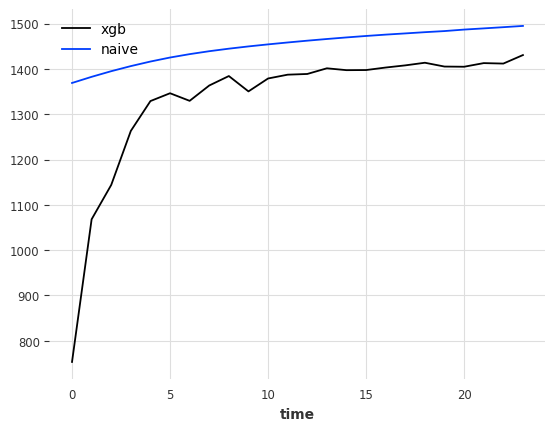

In [51]:
pd.concat(
    [
        metric_by_horizon(candidate_errors, rmse, "xgb"),
        metric_by_horizon(naive_errors, rmse, "naive"),
    ],
    axis=1,
).plot()